# Object Detection with SSD
### Here we demostrate detection on example images using SSD with PyTorch

In [2]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
from torch.autograd import Variable
import torch.utils.data as data
import torchvision.transforms as transforms
from torch.utils.serialization import load_lua
import numpy as np
import cv2
if torch.cuda.is_available():
    torch.set_default_tensor_type('torch.cuda.FloatTensor')

from ssd import build_ssd
# from models import build_ssd as build_ssd_v1 # uncomment for older pool6 model

## Build SSD300 in Test Phase
1. Build the architecture, specifyingsize of the input image (300),
    and number of object classes to score (21 for VOC dataset)
2. Next we load pretrained weights on the VOC0712 trainval dataset  

In [3]:
net = build_ssd('test', 300, 3)    # initialize SSD 21 classes (num classes + 1)
# net.load_weights('weights/ssd300_mAP_77.43_v2.pth')
# net.load_weights('weights/ssd300_mAP_77.43_v2.pth')
weight_file = 'weights/ssd1166_bhjctrained_finalv2_20180319135748.pth'
net.load_weights(weight_file)


 0.0034  0.0034  0.0100  0.0100
 0.0034  0.0034  0.0142  0.0142
 0.0034  0.0034  0.0142  0.0071
               ⋮                
 0.9700  0.9700  0.0961  0.0961
 0.9700  0.9700  0.1244  0.0622
 0.9700  0.9700  0.0622  0.1244
[torch.FloatTensor of size 129674x4]

Loading weights into state dict...
Finished!


## Load Image 
### Here we just load a sample image from the VOC07 dataset 

(1166, 1583, 3)


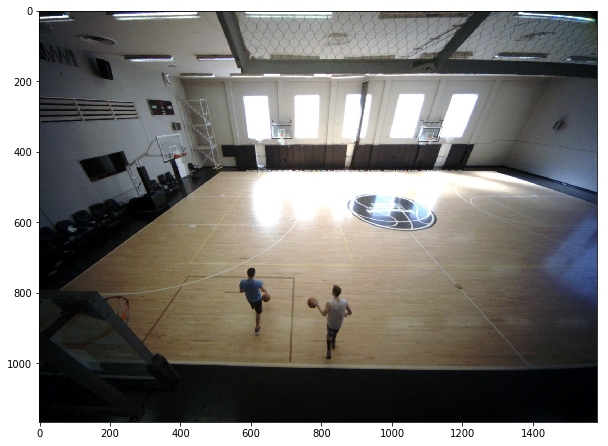

In [4]:
# image = cv2.imread('./data/example.jpg', cv2.IMREAD_COLOR)  # uncomment if dataset not downloaded
%matplotlib inline
from matplotlib import pyplot as plt
from data import VOCDetection, VOCroot, AnnotationTransform
# here we specify year (07 or 12) and dataset ('test', 'val', 'train') 
# Change the default VOCroot that was imported to the VOCroot on my machine(the VOCdevkit directory)
# VOCroot = '/Users/keith.landry/code/ssd.pytorch/data/VOCdevkit/'
# testset = VOCDetection(VOCroot, [('2007', 'val')], None, AnnotationTransform())
# img_id = 60
# image = testset.pull_image(img_id)

path_to_bball_im = '/Users/keith.landry/data/internal-experiments/basketball/bhjc/20180123/images/left_cam/'
# bball_file = 'left_scene2_rot180_00896_crop3.png'
# bball_file = 'left_scene2_rot180_00792_crop2.png'
# bball_file = 'left_scene2_rot180_00792.png'
bball_file = 'left_scene2_rot180_00132.png' # 442, 531, 855, 132

# path_to_bball_im = '/Users/keith.landry/Desktop/'
# bball_file = 'ghost.jpg'


# path_to_bball_im = '/Users/keith.landry/Documents/'
# bball_file = 'bballtest.jpg'

image = cv2.imread(path_to_bball_im + bball_file, cv2.IMREAD_COLOR)
print(image.shape)

rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# View the sampled input image before transform
plt.figure(figsize=(10, 10))
plt.imshow(rgb_image)
plt.show()


## Pre-process the input.  
#### Using the torchvision package, we can create a Compose of multiple built-in transorm ops to apply 
For SSD, at test time we use a custom BaseTransform callable to
resize our image to 300x300, subtract the dataset's mean rgb values, 
and swap the color channels for input to SSD300.

In [5]:
x = cv2.resize(image, (1166, 1166)).astype(np.float32)
# x = cv2.resize(image, (300, 300)).astype(np.float32)
# x -= (104, 117, 123)  #VOC means
x -= (103, 100, 94)   #BHJC means

# plt.imshow(x.astype(int))
x = x[:, :, ::-1].copy()
x = x.astype(np.float32)

x = torch.from_numpy(x).permute(2, 0, 1)
x.shape

torch.Size([3, 1166, 1166])

## SSD Forward Pass
### Now just wrap the image in a Variable so it is recognized by PyTorch autograd

In [6]:
xx = Variable(x.unsqueeze(0))     # wrap tensor in Variable
if torch.cuda.is_available():
    xx = xx.cuda()
y = net(xx)  # passes image through pretrained network

-----loc torch.Size([1, 518696])

 4.1025e-02  1.1972e-01  4.2012e-01  7.4819e-01
-5.1372e-01 -8.1088e-01 -6.6648e-01  2.1991e-01
-1.5315e+00  1.9976e-02 -3.6487e-01 -2.7204e-01
                       ⋮                        
 4.3724e-01  2.4266e+00  7.8878e-01  1.2572e+00
 1.6059e+00 -1.6405e+00  9.1603e-01 -1.6673e+00
 2.6672e+00  1.7330e+00  4.0184e-01 -2.3891e+00
[torch.FloatTensor of size 129674x4]


 0.0034  0.0034  0.0100  0.0100
 0.0034  0.0034  0.0142  0.0142
 0.0034  0.0034  0.0142  0.0071
               ⋮                
 0.9700  0.9700  0.0961  0.0961
 0.9700  0.9700  0.1244  0.0622
 0.9700  0.9700  0.0622  0.1244
[torch.FloatTensor of size 129674x4]



## Parse the Detections and View Results
Filter outputs with confidence scores lower than a threshold 
Here we choose 60% 

In [7]:
# from data import VOC_CLASSES as labels
from data.bhjc20180123_bball.bhjc import CLASSES as labels
top_k = 10

plt.figure(figsize=(15, 15))
colors = plt.cm.hsv(np.linspace(0, 1, 21)).tolist()
plt.imshow(rgb_image)  # plot the image for matplotlib
currentAxis = plt.gca()

detections = y.data
# scale each detection back up to the image
scale = torch.Tensor(rgb_image.shape[1::-1]).repeat(2)
for i in range(detections.size(1)):
# for i in [2]:  # just label people
    j = 0
    while detections[0, i, j, 0] >= .7:
        score = detections[0, i, j, 0]
        label_name = labels[i-1]
        display_txt = '%s: %.2f'%(label_name, score)
        pt = (detections[0, i, j, 1:]*scale).cpu().numpy()
        # pt = (detections[0, i, j, 1:]).cpu().numpy()

        coords = (pt[0], pt[1]), pt[2]-pt[0]+1, pt[3]-pt[1]+1
        print(label_name, score, coords)
        color = colors[i]
        currentAxis.add_patch(plt.Rectangle(*coords, fill=False, edgecolor=color, linewidth=2))
        currentAxis.text(pt[0], pt[1], display_txt, bbox={'facecolor': color, 'alpha': 0.5})
        j += 1

person 1.0 ((-59723.508, -11097.161), 120118.671875, 21954.341796875)
person 1.0 ((1456.7094, -19730496.0), 1.039794921875, 39462945.0)
person 1.0 ((1404.7405, -14566424.0), 1.0771484375, 29134833.0)
person 1.0 ((1377.2216, -12693981.0), 1.0936279296875, 25389957.0)
person 1.0 ((1451.2002, -6820253.5), 1.0657958984375, 13640957.0)
person 1.0 ((1354.7599, -11651236.0), 1.0997314453125, 23304465.0)
person 1.0 ((1463.4484, -233714.38), 1.753662109375, 467892.375)
person 1.0 ((1468.6277, -674424.38), 1.59814453125, 1350822.75)
person 1.0 ((1469.788, -43852.727), 2.07177734375, 88163.96875)
person 1.0 ((1627.905, -172529.23), 1.138671875, 345440.03125)
person 1.0 ((1491.7368, -42355.805), 2.0518798828125, 85169.328125)
person 1.0 ((1289.3733, -10958957.0), 1.1007080078125, 21919909.0)
person 1.0 ((1515.188, -44385.859), 2.0001220703125, 89227.453125)
person 1.0 ((1266.9911, -10623132.0), 1.1026611328125, 21248257.0)
person 1.0 ((1542.7937, -45388.977), 1.8985595703125, 91226.828125)
person 

 1.0 ((1266.8384, -12625624.0), 1.0947265625, 25253273.0)
person 1.0 ((1404.6486, -17441206.0), 1.0709228515625, 34884433.0)
person 1.0 ((1289.0706, -12638961.0), 1.09423828125, 25279949.0)
person 1.0 ((961.39453, -1.7744488e+11), 1.00164794921875, 354889760769.0)
person 1.0 ((1355.1833, -14738681.0), 1.08935546875, 29479389.0)
person 1.0 ((986.06177, -1.6893975e+11), 1.0015869140625, 337879498753.0)
person 1.0 ((1334.1746, -13879919.0), 1.0916748046875, 27761865.0)
person 1.0 ((1011.2065, -1.7165284e+11), 1.00164794921875, 343305682945.0)
person 1.0 ((1311.7374, -13032538.0), 1.0933837890625, 26067105.0)
person 1.0 ((1456.5685, -23062046.0), 1.036865234375, 46126081.0)
person 1.0 ((1377.3221, -15712491.0), 1.0845947265625, 31427009.0)
person 1.0 ((1277.1946, -3.6028746e+08), 1.025634765625, 720575361.0)
person 1.0 ((236.6944, -1.1584934e+08), 1.034576416015625, 231700737.0)
person 1.0 ((1297.9281, -1.6506603e+08), 1.0367431640625, 330132577.0)
person 1.0 ((581.72504, -44230780.0), 1.0

 1.0 ((196.26138, -1.7978202e+08), 1.026763916015625, 359566017.0)
person 1.0 ((172.1322, -1.9615698e+08), 1.0258026123046875, 392315905.0)
person 1.0 ((147.74518, -1.8282683e+08), 1.0261077880859375, 365655617.0)
person 1.0 ((120.40959, -1.0069975e+08), 1.0319976806640625, 201401489.0)
person 1.0 ((305.33575, -1.0325802e+08), 1.0357666015625, 206518017.0)
person 1.0 ((260.18097, -1.1422919e+08), 1.034088134765625, 228460369.0)
person 1.0 ((430.50482, -4.5053587e+08), 1.0191650390625, 901072321.0)
person 1.0 ((412.0368, -64728472.0), 1.045013427734375, 129458945.0)
person 1.0 ((450.95941, -7.8717459e+08), 1.015472412109375, 1574349825.0)
person 1.0 ((950.362, -68724560.0), 1.03973388671875, 137451057.0)
basketball 1.0 ((731.21216, -532.30072), 1.11358642578125, 1.00006103515625)
basketball 1.0 ((1263.2135, -411.61481), 1.005126953125, 1.0)
basketball 1.0 ((1142.0516, 405.95822), 1.106201171875, 1.000091552734375)
basketball 1.0 ((1120.2922, 404.6922), 1.099365234375, 1.0001220703125)
b

1.0 ((1249.9199, 403.04031), 1.114990234375, 1.000152587890625)
basketball 1.0 ((226.57362, -163.14243), 1.0494537353515625, 1.0000152587890625)
basketball 1.0 ((1142.5463, 394.17111), 1.1109619140625, 1.000091552734375)
basketball 1.0 ((247.82063, -168.84641), 1.0435943603515625, 1.000030517578125)
basketball 1.0 ((314.28171, -196.36885), 1.0472412109375, 1.000030517578125)
basketball 1.0 ((269.06097, -176.52075), 1.045928955078125, 1.0000152587890625)
basketball 1.0 ((1186.345, 396.02133), 1.11181640625, 1.0001220703125)
basketball 1.0 ((291.20389, -187.81824), 1.050811767578125, 1.0000152587890625)
basketball 1.0 ((1229.0447, 401.69592), 1.1094970703125, 1.000152587890625)
basketball 1.0 ((1208.0912, 399.16965), 1.1075439453125, 1.000152587890625)
basketball 1.0 ((908.55908, 323.9949), 1.06756591796875, 1.000030517578125)
basketball 1.0 ((602.0589, 336.96414), 1.080810546875, 1.000030517578125)
basketball 1.0 ((580.18005, 340.0369), 1.08148193359375, 1.000030517578125)
basketball 1.

ValueError: Image size of 32520x660699500 pixels is too large. It must be less than 2^16 in each direction.

In [14]:
labels

['basketball']

In [8]:
net.priorbox.max_sizes

[233, 431, 630, 828, 1027, 1224]

In [16]:
detections.size(1)

3

In [8]:
net.priorbox.min_sizes

[1, 80, 80, 80, 80, 80]

In [14]:
detections


( 0 , 0 ,.,.) = 
  0.0000  0.0000  0.0000  0.0000  0.0000
  0.0000  0.0000  0.0000  0.0000  0.0000
  0.0000  0.0000  0.0000  0.0000  0.0000
                   ⋮                    
  0.0000  0.0000  0.0000  0.0000  0.0000
  0.0000  0.0000  0.0000  0.0000  0.0000
  0.0000  0.0000  0.0000  0.0000  0.0000

( 0 , 1 ,.,.) = 
  0.9984  0.1407 -0.0353  1.2020  1.4445
  0.9939  0.1870  0.0605  0.8393  0.8421
  0.9930  0.2576 -0.3227  1.0652  0.9286
                   ⋮                    
  0.0000  0.0000  0.0000  0.0000  0.0000
  0.0000  0.0000  0.0000  0.0000  0.0000
  0.0000  0.0000  0.0000  0.0000  0.0000

( 0 , 2 ,.,.) = 
  1.0000  0.3461  0.3099  0.3900  2.1194
  1.0000  0.3679  0.2643  0.4228  2.0221
  1.0000  0.4256  0.0602  0.4780  1.8144
                   ⋮                    
  0.0000  0.0000  0.0000  0.0000  0.0000
  0.0000  0.0000  0.0000  0.0000  0.0000
  0.0000  0.0000  0.0000  0.0000  0.0000
[torch.FloatTensor of size 1x3x200x5]

In [17]:
detections.size(1)

3

In [12]:
y

Variable containing:
( 0 , 0 ,.,.) = 
  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00
  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00
  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00
                             ⋮                              
  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00
  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00
  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00

( 0 , 1 ,.,.) = 
  1.0000e+00 -2.1727e-01 -1.2607e+00 -2.1727e-01 -1.5810e-01
  1.0000e+00 -4.1492e-01 -5.3531e+01 -4.1492e-01  4.9372e+01
  1.0000e+00 -4.1102e+13  3.7781e-01  4.1102e+13  3.7781e-01
                             ⋮                              
  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00
  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00
  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00
[torch.FloatTensor of size 1x2x200x5]

In [13]:
y.data


( 0 , 0 ,.,.) = 
  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00
  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00
  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00
                             ⋮                              
  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00
  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00
  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00

( 0 , 1 ,.,.) = 
  1.0000e+00 -2.1727e-01 -1.2607e+00 -2.1727e-01 -1.5810e-01
  1.0000e+00 -4.1492e-01 -5.3531e+01 -4.1492e-01  4.9372e+01
  1.0000e+00 -4.1102e+13  3.7781e-01  4.1102e+13  3.7781e-01
                             ⋮                              
  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00
  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00
  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00
[torch.FloatTensor of size 1x2x200x5]

In [25]:
detections


( 0 , 0 ,.,.) = 
  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00
  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00
  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00
                             ⋮                              
  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00
  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00
  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00

( 0 , 1 ,.,.) = 
  1.0000e+00 -4.7736e+02 -1.9924e+07  4.4584e+02  1.9924e+07
  1.0000e+00  2.6378e+01  1.4359e+02  2.6378e+01  1.4359e+02
  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00
                             ⋮                              
  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00
  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00
  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00
[torch.FloatTensor of size 1x2x200x5]

In [34]:
detections


( 0 , 0 ,.,.) = 
    0.0000    0.0000    0.0000    0.0000    0.0000
    0.0000    0.0000    0.0000    0.0000    0.0000
    0.0000    0.0000    0.0000    0.0000    0.0000
                        ⋮                         
    0.0000    0.0000    0.0000    0.0000    0.0000
    0.0000    0.0000    0.0000    0.0000    0.0000
    0.0000    0.0000    0.0000    0.0000    0.0000

( 0 , 1 ,.,.) = 
    1.0000  -67.9985 -199.7341  -67.9985 -199.7341
    0.0000    0.0000    0.0000    0.0000    0.0000
    0.0000    0.0000    0.0000    0.0000    0.0000
                        ⋮                         
    0.0000    0.0000    0.0000    0.0000    0.0000
    0.0000    0.0000    0.0000    0.0000    0.0000
    0.0000    0.0000    0.0000    0.0000    0.0000
[torch.FloatTensor of size 1x2x200x5]

3